# Modifying Readability with GPT

*Author: Sean Trott*

In this notebook, I ask whether LLMs can be used to **modify** the readability of a text excerpt. Additionally, I conduct several *evaluations* of this process using traditional readability formulas and GPT-4 Turbo.

Relevant sections:

1. **Setup**: import libraries, CLEAR dataset; select *random subset* of CLEAR. 
2. **Modifying readability**: use GPT-4 Turbo to produce a `Hard` and `Easy` version of a text. 
3. **Assessing readability**: use GPT-4 Turbo to assess the readability of these new texts.  
4. **Analysis**: apply other readability formulas to texts; run pre-registered analyses.

## 1. Setup

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tiktoken
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as ssm
import scipy.stats as ss
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler

### Seaborn theme
sns.set_theme(style="white", palette='crest')
sns.set(style='whitegrid',font_scale=1.2,palette='crest')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

In [2]:
### Styling
# Get the Mako palette
palette = sns.color_palette("mako", 3)

# Select colors from opposite ends
color1 = palette[0]  # First color
color2 = palette[-1] # Last color
color3 = palette[3 // 2]

### Set up GPT

In [3]:
from openai import OpenAI
import openai
client = OpenAI()

In [4]:
enc = tiktoken.encoding_for_model("gpt-4")

def count_tokens(excerpt):
    o = enc.encode(excerpt)
    return len(o)

print(count_tokens("This is a test"))
print(count_tokens("John vanquished the dragon"))

4
6


### Create dataset

The original CLEAR corpus is too large to run a tractable study. Thus, I select a random *subset* from that corpus of 100 texts for this pilot study.

In [4]:
df = pd.read_csv("../data/raw/CLEAR_corpus_final.csv")
df.shape

(4724, 28)

In [5]:
df_subset = df.sample(100, random_state=1).reset_index()
df_subset.shape

(100, 29)

In [6]:
df_subset.head(2)

,index,ID,Author,Title,Anthology,URL,Pub Year,Categ,Sub Cat,Lexile Band,...,BT_easiness,s.e.,Flesch-Reading-Ease,Flesch-Kincaid-Grade-Level,Automated Readability Index,SMOG Readability,New Dale-Chall Readability Formula,CAREC,CAREC_M,CML2RI
0,3403,5759,Uncle Charles,HOW SMART MANAGED THE SHEEP,"The Nursery, January 1873, Vol. XIII.\n ...",http://www.gutenberg.org/files/24474/24474-h/2...,1873.0,Lit,NaN,1300,...,-0.001623,0.464634,78.53,9.12,10.75,7.0,6.40,0.07776,0.06604,23.940588
1,589,2124,wikipedia,Impeachment,NaN,https://en.wikipedia.org/wiki/Impeachment,2020.0,Info,History,1300,...,-1.314291,0.472263,31.25,14.49,15.13,16.0,11.42,0.33734,0.31784,2.505195


<Axes: xlabel='BT_easiness', ylabel='Count'>

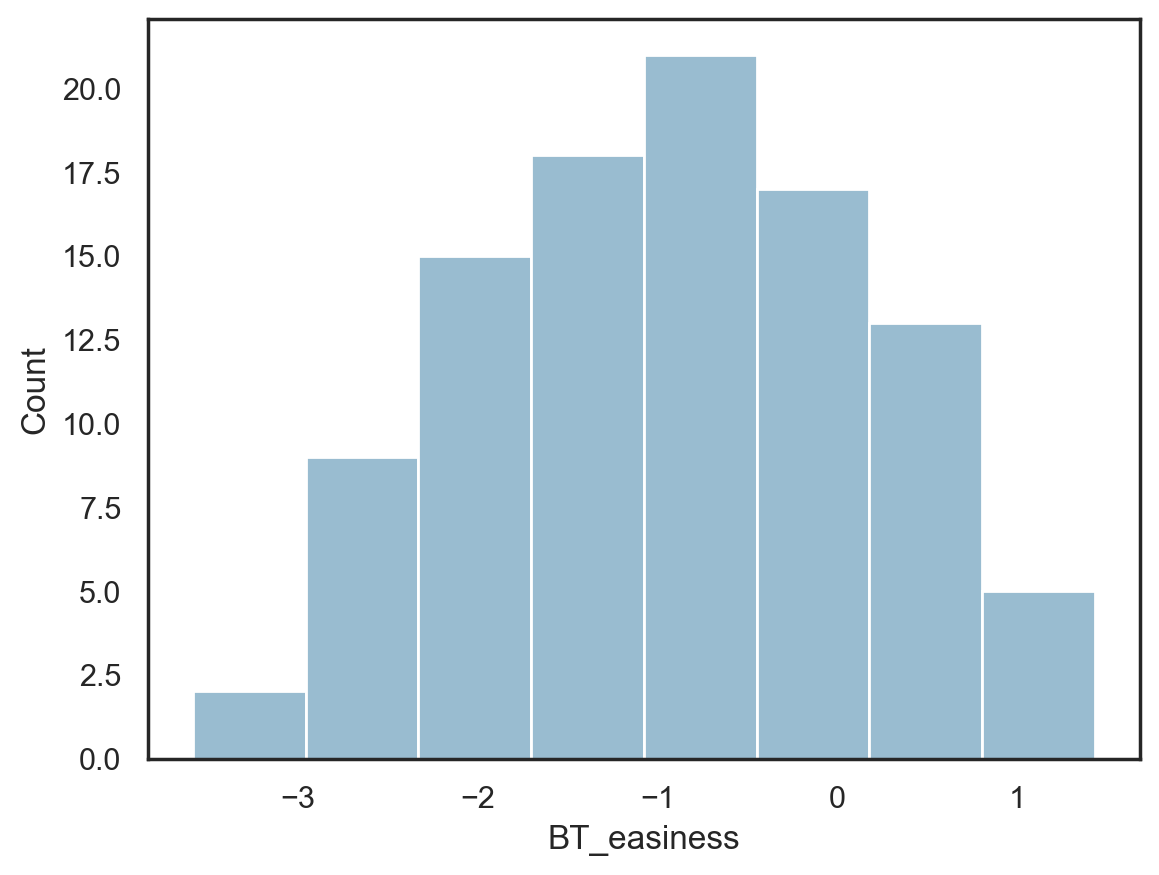

In [7]:
sns.histplot(data = df_subset, x = "BT_easiness", color = color3, alpha = .5)

## 2. Modifying Readability

In this section, I use GPT-4 Turbo to **modify** the readability of each of these text excerpts.

### Helper functions

In [8]:
import backoff  # for exponential backoff

In [9]:
@backoff.on_exception(backoff.expo, openai.RateLimitError)
def pred_tokens(prompt, system_prompt, max_tokens=100, model="gpt-4", temperature = 0):
    """Get response."""
    completion = client.chat.completions.create(
      model=MODEL,
      messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt}
      ],
        max_tokens = max_tokens,
        temperature = temperature,
        n = 1
    )

    return completion# output['choices'][0]['message']['content']

### Modification code

In [11]:
more_readable_instr = """Read the passage below. Then, rewrite the passage so that it is easier to read.

When making the passage more readable, consider factors such as sentence structure, vocabulary complexity, and overall clarity. However, make sure that the passage conveys the same content.

Finally, try to make the new version approximately the same length as the original version."""

In [12]:
less_readable_instr = """Read the passage below. Then, rewrite the passage so that it is harder to read.

When making the passage less readable, consider factors such as sentence structure, vocabulary complexity, and overall clarity. However, make sure that the passage conveys the same content.

Finally, make sure the new version is approximately the same length as the original version."""

In [13]:
GOALS = {'easier': more_readable_instr,
        'harder': less_readable_instr}

In [17]:
### Format prompt with text. 
def format_prompt(instructions, text, goal):
    final = instructions + "\n\n<Text>:{text}</Text>\n\nAs described in the instructions, please make this passage {goal} to read, while keeping the length the same.".format(text = text, goal = goal)
    return final

In [18]:
### Set up system prompt and isntructions
system_prompt = "You are an experienced writer, skilled at rewriting texts."


In [19]:
### Set up parameters
MODEL = "gpt-4-1106-preview"
BUFFER_TOKENS = 5

In [20]:
results = []

for index, row in tqdm(df_subset.iterrows(), total = len(df_subset)):
    
    excerpt = row['Excerpt']
    
    ### get num_tokens
    num_tokens = count_tokens(excerpt)
    target_tokens_with_buffer = num_tokens + BUFFER_TOKENS
    
    ### Modify twice: make easier and harder
    for goal, instr in GOALS.items():
    
        ### Format using prompt
        prompt = format_prompt(instr, excerpt, goal = goal)

    
        ### Obtain completion, allowing for backoff
        completion = pred_tokens(prompt = prompt, 
                                 system_prompt = system_prompt,
                                 temperature=0,
                                max_tokens = target_tokens_with_buffer, # set upper bound to be num_tokens in excerpt + ~5
                                model = MODEL)
    
        ### Replace newline characters to avoid text processing issues later
        text_modified = excerpt.replace('\n', '\\n')
    
        ### Write output to output file
        # with open(OUTPUT_PATH, "a") as f:
        #    f.write("{excerpt}\t{response}\n".format(excerpt = text_modified, 
        #                                            response = completion.choices[0].message.content))

        ### Also track in DataFrame
        results.append({
            'Original': excerpt,
            'GPT_Response': completion.choices[0].message.content,
            'Goal': goal
        })

100%|█████████████████████████████████████████| 100/100 [43:02<00:00, 25.83s/it]


In [21]:
df_results = pd.DataFrame(results)

In [22]:
df_results.shape

(200, 3)

In [23]:
df_results.to_csv("../data/processed/modified/{model}_modified.csv".format(model=MODEL), index = False)

## 3. Assessing Readability with GPT-4 Turbo

In this section, we use GPT-4 Turbo to *assess* the readability of those modified passages.

In [187]:
df_results = pd.read_csv("../data/processed/modified/gpt-4-1106-preview_modified.csv")

### Setup

In [188]:
### Set up system prompt and isntructions
system_prompt = "You are an experienced teacher, skilled at identifying the readability of different texts."
instructions = "Read the text below. Then, indicate the readability of the text, on a scale from 1 (extremely challenging to understand) to 100 (very easy to read and understand). In your assessment, consider factors such as sentence structure, vocabulary complexity, and overall clarity."

In [189]:
@backoff.on_exception(backoff.expo, openai.RateLimitError)
def pred_tokens(prompt, system_prompt, n=10, model="gpt-4", temperature = 0):
    """Get response."""
    completion = client.chat.completions.create(
      model=MODEL,
      messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt}
      ],
        n = n,
        temperature = temperature
    )

    return completion# output['choices'][0]['message']['content']

### Helper functions
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def get_number(ans):
    """Retrieves number from GPT-4 response."""
    if type(ans) is int:
        return ans
    res = [float(i) for i in ans.split() if is_number(i)]
    if len(res) == 0:
        return None
    return res[0]

### Format prompt with text. 
def format_prompt(instructions, text):
    final = instructions + "\n\n<Text>:{text}</Text>\n\nOn a scale from 1 (extremely challenging to understand) to 100 (very easy to read and understand), how readable is this text?. Please answer with a single number.".format(text = text)
    return final

### Extract readability

In [190]:
### Set up parameters
MODEL = "gpt-4-1106-preview"

In [191]:
gpt_readability_results = []

for index, row in tqdm(df_results.iterrows(), total = len(df_results)):
    
    excerpt = row['GPT_Response']
    
    ### Format using prompt
    prompt = format_prompt(instructions, excerpt)
    
    ### Obtain completion, allowing for backoff
    completion = pred_tokens(prompt = prompt, 
                             system_prompt = system_prompt,
                            n = 3,
                            model = MODEL)
    
    ### Also track in DataFrame
    gpt_readability_results.append({
        'Excerpt': row['Original'],
        'GPT_Response': excerpt,
        'GPT_Rating': completion.choices[0].message.content
    })

100%|█████████████████████████████████████████| 200/200 [03:08<00:00,  1.06it/s]


In [192]:
df_gpt_readability_results = pd.DataFrame(gpt_readability_results)
df_gpt_readability_results.head(5)

,Excerpt,GPT_Response,GPT_Rating
0,"Mr. Scott's dog Smart was so trained, that he ...",Mr. Scott had trained his dog Smart so well th...,85
1,"Mr. Scott's dog Smart was so trained, that he ...","Mr. Scott's canine, denominated Smart, exhibit...",20
2,Impeachment is a process in which an official ...,Impeachment is when an official is charged wit...,85
3,Impeachment is a process in which an official ...,Impeachment constitutes a procedural mechanism...,20
4,"One day, the people of Mongu held a meeting. T...","One day, the villagers of Mongu gathered toget...",85


In [193]:
### Process numeric results
df_gpt_readability_results['GPT_rating_modified'] = df_gpt_readability_results['GPT_Rating'].apply(lambda x: get_number(x))
df_gpt_readability_results['GPT_rating_modified'].mean()

51.575

In [194]:
### Remove NA
df_gpt_readability_results = df_gpt_readability_results.dropna()
df_gpt_readability_results.shape

(200, 4)

In [195]:
df_gpt_readability_results = df_gpt_readability_results[['Excerpt', 'GPT_Response', 'GPT_rating_modified']]

In [196]:
df_gpt_readability_results.head(2)

,Excerpt,GPT_Response,GPT_rating_modified
0,"Mr. Scott's dog Smart was so trained, that he ...",Mr. Scott had trained his dog Smart so well th...,85.0
1,"Mr. Scott's dog Smart was so trained, that he ...","Mr. Scott's canine, denominated Smart, exhibit...",20.0


In [197]:
df_gpt_readability_results.head(2)

,Excerpt,GPT_Response,GPT_rating_modified
0,"Mr. Scott's dog Smart was so trained, that he ...",Mr. Scott had trained his dog Smart so well th...,85.0
1,"Mr. Scott's dog Smart was so trained, that he ...","Mr. Scott's canine, denominated Smart, exhibit...",20.0


### Merge with GPT-4 Ratings for original

In [203]:
df_gpt_ratings_original = pd.read_csv("../data/processed/readability_basic_gpt-4-1106-preview.csv")
df_gpt_ratings_original['GPT_rating_original'] = df_gpt_ratings_original['GPT_Response']
df_gpt_ratings_original = df_gpt_ratings_original[['Excerpt', 'GPT_rating_original']]
df_gpt_ratings_original.head(2)

,Excerpt,GPT_rating_original
0,When the young people returned to the ballroom...,85
1,"All through dinner time, Mrs. Fayre was somewh...",75


In [204]:
### Process numeric results
df_gpt_ratings_original['GPT_rating_original'] = df_gpt_ratings_original['GPT_rating_original'].apply(lambda x: get_number(x))
df_gpt_ratings_original['GPT_rating_original'].mean()

70.56731583403895

In [205]:
df_merged_gpt_ratings = pd.merge(df_gpt_ratings_original, df_gpt_readability_results, on = "Excerpt")
df_merged_gpt_ratings.head(2)

,Excerpt,GPT_rating_original,GPT_Response,GPT_rating_modified
0,"Then the man took off his hat and walked away,...",85.0,The man tipped his hat and left. Philip and hi...,85.0
1,"Then the man took off his hat and walked away,...",85.0,"Subsequently, the gentleman doffed his headgea...",25.0


In [206]:
df_merged_gpt_ratings.shape

(200, 4)

In [207]:
### Add condition ifno
df_merged_gpt_ratings_with_condition = pd.merge(df_merged_gpt_ratings, df_results)
df_merged_gpt_ratings_with_condition.head(2)

,Excerpt,GPT_rating_original,GPT_Response,GPT_rating_modified,Original,Goal
0,"Then the man took off his hat and walked away,...",85.0,The man tipped his hat and left. Philip and hi...,85.0,"Then the man took off his hat and walked away,...",easier
1,"Then the man took off his hat and walked away,...",85.0,"Subsequently, the gentleman doffed his headgea...",25.0,"Then the man took off his hat and walked away,...",harder


In [208]:
### save to .csv
df_merged_gpt_ratings_with_condition.to_csv("../data/processed/modified/{model}_modified_and_original_gpt_ratings.csv".format(model=MODEL), index = False)

## 4. Analysis

In this section, we analyze the *original* and *modified* passages using a handful of readability formulas, as well as the GPT-4 Turbo ratings.

In [5]:
import textstat

In [6]:
df_results = pd.read_csv("../data/processed/modified/gpt-4-1106-preview_modified_and_original_gpt_ratings.csv")

In [7]:
### Reading scores
df_results['Og_Flesch'] = df_results['Original'].apply(textstat.flesch_reading_ease)
df_results['Modified_Flesch'] = df_results['GPT_Response'].apply(textstat.flesch_reading_ease)
df_results['Og_SMOG'] = df_results['Original'].apply(textstat.smog_index)
df_results['Modified_SMOG'] = df_results['GPT_Response'].apply(textstat.smog_index)
df_results['Og_ARI'] = df_results['Original'].apply(textstat.automated_readability_index)
df_results['Modified_ARI'] = df_results['GPT_Response'].apply(textstat.automated_readability_index)

### Basics
df_results['Og_Length'] = df_results['Original'].apply(lambda x: count_tokens(x))
df_results['Modified_Length'] = df_results['GPT_Response'].apply(lambda x: count_tokens(x))

### Basics
df_results['SMOG_diff'] = df_results['Og_SMOG'] - df_results['Modified_SMOG']
df_results['ARI_diff'] = df_results['Og_ARI'] - df_results['Modified_ARI']
df_results['Flesch_diff'] = df_results['Og_Flesch'] - df_results['Modified_Flesch']
df_results['GPT_diff'] = df_results['GPT_rating_original'] - df_results['GPT_rating_modified']
df_results['Length_diff'] = df_results['Og_Length'] - df_results['Modified_Length']

In [8]:
### Set up some additional column names
df_results['Og_GPT'] = df_results['GPT_rating_original']
df_results['Modified_GPT'] = df_results['GPT_rating_modified']

In [9]:
### Setup goal columns
df_results['Goal'] = df_results['Goal'].apply(lambda x: x.title())

### Approach 1: `Easy` vs. `Hard`

In this approach, we predict each target text's readability using different metrics, and ask about the coefficient assigned to `Goal`. 

In [253]:
metrics = ['SMOG', 'ARI', 'Flesch', 'GPT']
approach1_results = []
    
for metric in metrics:
    target = "Modified_{m}".format(m = metric)
    og = "Og_{m}".format(m = metric)
    
    formula_full = "{t} ~ Goal + {og} + Length_diff".format(t = target, og = og)
    formula_reduced = "{t} ~ {og} + Length_diff".format(t = target, og = og)
    
    ## Fit full and reduced models
    mod_full = smf.ols(data = df_results, formula = formula_full).fit()
    mod_reduced = smf.ols(data = df_results, formula = formula_reduced).fit()
    
    ## name for predictor
    og_pred = "{og}_coef".format(og=og)
    
    approach1_results.append({
        'Metric': metric,
        'r2_full': mod_full.rsquared,
        'r2_reduced': mod_reduced.rsquared,
        'Intercept_full': mod_full.params['Intercept'],
        'Goal_coef': mod_full.params['Goal[T.Harder]'],
        'Length_diff_coef': mod_full.params['Length_diff'],
        'Og_readability_coef': mod_full.params[og],
        'Goal_p': mod_full.pvalues['Goal[T.Harder]'],
        'Length_diff_p': mod_full.pvalues['Length_diff'],
        'Og_readability_p': mod_full.pvalues[og],
        'Goal_se': mod_full.bse['Goal[T.Harder]'],
        'Length_diff_se': mod_full.bse['Length_diff'],
        'Og_readability_se': mod_full.bse[og],
    })

In [254]:
### Concat into DataFrame
df_app1_results = pd.DataFrame(approach1_results)
df_app1_results

,Metric,r2_full,r2_reduced,Intercept_full,Goal_coef,Length_diff_coef,Og_readability_coef,Goal_p,Length_diff_p,Og_readability_p,Goal_se,Length_diff_se,Og_readability_se
0,SMOG,0.846272,0.620140,4.184761,7.432018,-0.023596,0.529658,2.318380e-40,0.031677,5.824994e-30,0.437698,0.010904,0.039078
1,ARI,0.864970,0.667158,3.505736,9.457017,-0.041549,0.528841,2.947558e-40,0.003159,2.068811e-41,0.558102,0.013902,0.030514
2,Flesch,0.910625,0.638085,38.215572,-49.483629,0.114476,0.520415,1.958459e-61,0.024063,9.478312e-36,2.024076,0.050346,0.033680
3,GPT,0.973273,0.623326,66.097443,-59.309834,0.068245,0.203154,1.470209e-114,0.020109,5.822951e-19,1.170770,0.029122,0.020545


In [255]:
### Zooming in on coefficients for goal
df_app1_results[['Metric', 'Goal_coef', 'Goal_se']]

,Metric,Goal_coef,Goal_se
0,SMOG,7.432018,0.437698
1,ARI,9.457017,0.558102
2,Flesch,-49.483629,2.024076
3,GPT,-59.309834,1.170770


In [256]:
### Double-checking p-value post-correction
ssm.multipletests(df_app1_results['Goal_p'].values, method = "holm")

(array([ True,  True,  True,  True]),
 array([4.63675965e-040, 4.63675965e-040, 5.87537840e-061, 5.88083714e-114]),
 0.012741455098566168,
 0.0125)

In [257]:
### Comparing R^2
df_app1_r2_melted = pd.melt(df_app1_results[['Metric', 'r2_full', 'r2_reduced']], 
                            id_vars = "Metric",
                           var_name = "Model",
                           value_name = "R2")
df_app1_r2_melted['Model'] = df_app1_r2_melted['Model'].map({'r2_full': 'Full', 'r2_reduced': 'Reduced'})
df_app1_r2_melted.head(2)

,Metric,Model,R2
0,SMOG,Full,0.846272
1,ARI,Full,0.864970


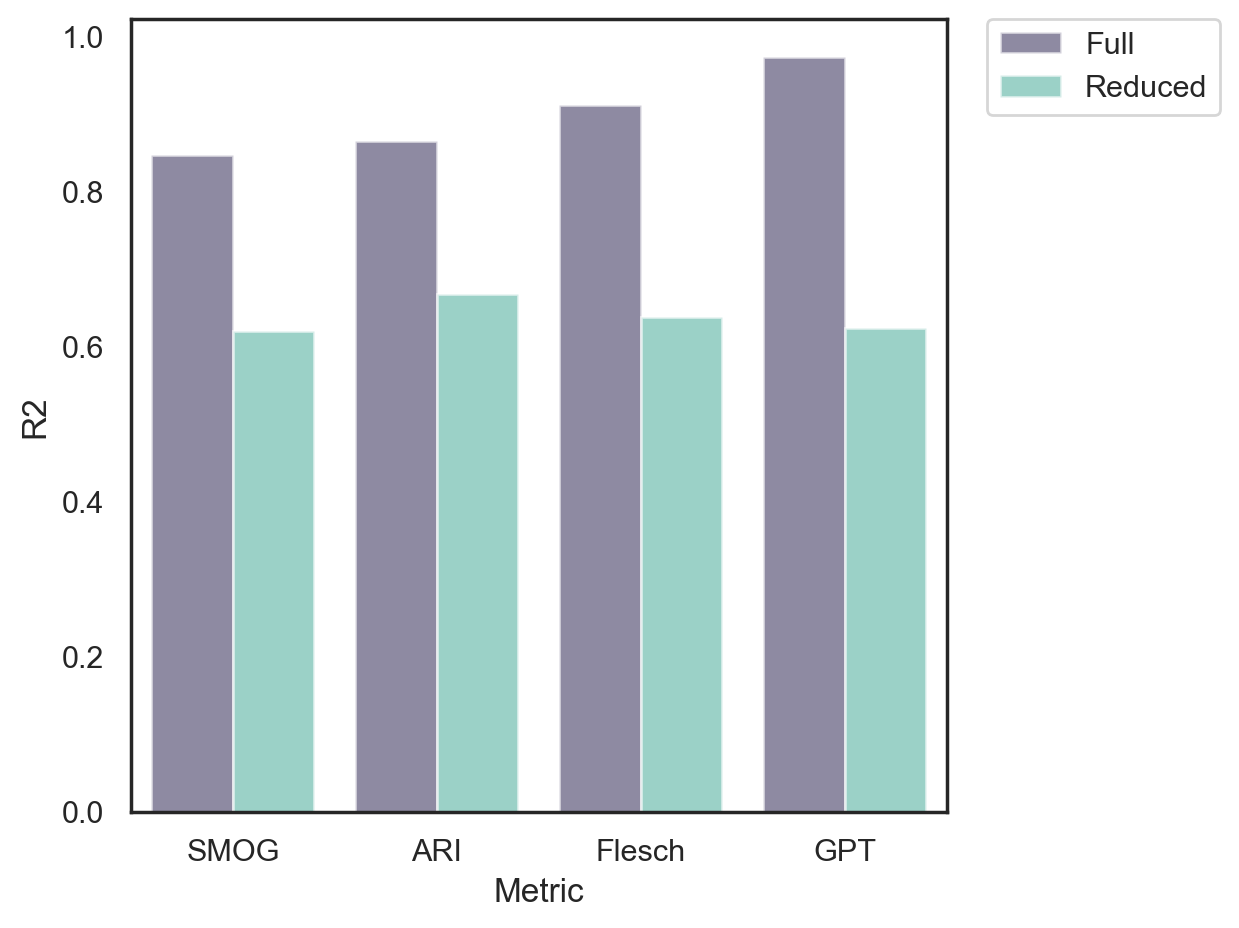

In [258]:
sns.barplot(data = df_app1_r2_melted, 
            x = "Metric", 
            y = "R2", 
            hue = "Model", 
            alpha = .6,
            palette = [color1, color2])

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()

### Approach 2: `Easy/Hard` vs. `Original`

In this approach, we ask whether the **Intercept** of a model predicting the *Difference* is significantly different from zero for both `Easy` and `Hard` cases.

In [26]:
df_results['Og_GPT'] = df_results['GPT_rating_original']
df_results['Modified_GPT'] = df_results['GPT_rating_modified']

#### `Easy` cases

In [70]:
df_easy = df_results[df_results['Goal'] == 'Easier']

In [71]:
metrics = ['SMOG', 'ARI', 'Flesch', 'GPT']
approach2_results = []
    
for metric in metrics:
    target = "{m}_diff".format(m = metric)
    og = "Og_{m}".format(m = metric)
    
    formula_full = "{t} ~ 1".format(t = target, og = og)
    
    ## Fit full and reduced models
    mod_full = smf.ols(data = df_easy, formula = formula_full).fit()
    
    approach2_results.append({
        'Metric': metric,
        'Intercept_full': mod_full.params['Intercept'],
        'Intercept_p': mod_full.pvalues['Intercept']
    })

In [72]:
### Concat into DataFrame
df_app2_results = pd.DataFrame(approach2_results)
df_app2_results

,Metric,Intercept_full,Intercept_p
0,SMOG,1.1670,4.319478e-05
1,ARI,2.9560,1.032295e-09
2,Flesch,-7.9328,6.947127e-09
3,GPT,-11.4000,4.016334e-13


In [73]:
### Double-checking p-value post-correction
ssm.multipletests(df_app2_results['Intercept_p'].values, method = "holm")

(array([ True,  True,  True,  True]),
 array([4.31947843e-05, 3.09688600e-09, 1.38942546e-08, 1.60653367e-12]),
 0.012741455098566168,
 0.0125)

In [74]:
### Using t-test
metrics = ['SMOG', 'ARI', 'Flesch', 'GPT']
approach2_results = []
    
for metric in metrics:
    
    ## Get column names
    target = "Modified_{m}".format(m = metric)
    og = "Og_{m}".format(m = metric)
    
    ## Get actual numbers
    og_col = df_easy[og]
    target_col = df_easy[target]
    
    t = ss.ttest_rel(og_col, target_col)
    
    approach2_results.append({
        't': t.statistic,
        'pvalue': t.pvalue,
        'df': t.df,
        'Metric': metric
    })

In [75]:
### Concat into DataFrame
df_app2_results = pd.DataFrame(approach2_results)
df_app2_results

,t,pvalue,df,Metric
0,4.280228,4.319478e-05,99,SMOG
1,6.746211,1.032295e-09,99,ARI
2,-6.337705,6.947127e-09,99,Flesch
3,-8.361156,4.016334e-13,99,GPT


In [76]:
### Double-checking p-value post-correction
ssm.multipletests(df_app2_results['pvalue'].values, method = "holm")

(array([ True,  True,  True,  True]),
 array([4.31947843e-05, 3.09688600e-09, 1.38942546e-08, 1.60653367e-12]),
 0.012741455098566168,
 0.0125)

#### `Hard` cases

In [77]:
df_hard = df_results[df_results['Goal'] == 'Harder']

In [78]:
metrics = ['SMOG', 'ARI', 'Flesch', 'GPT']
approach2_results = []
    
for metric in metrics:
    target = "{m}_diff".format(m = metric)
    og = "Og_{m}".format(m = metric)
    
    formula_full = "{t} ~ 1".format(t = target, og = og)
    
    ## Fit full and reduced models
    mod_full = smf.ols(data = df_hard, formula = formula_full).fit()
    
    approach2_results.append({
        'Metric': metric,
        'Intercept_full': mod_full.params['Intercept'],
        'Intercept_p': mod_full.pvalues['Intercept']
    })

In [79]:
### Concat into DataFrame
df_app2_results = pd.DataFrame(approach2_results)
df_app2_results

,Metric,Intercept_full,Intercept_p
0,SMOG,-7.0050,4.114454e-50
1,ARI,-7.8040,1.093139e-46
2,Flesch,45.1408,1.060282e-56
3,GPT,50.0500,2.237092e-51


In [80]:
### Using t-test
metrics = ['SMOG', 'ARI', 'Flesch', 'GPT']
approach2_results = []
    
for metric in metrics:
    
    ## Get column names
    target = "Modified_{m}".format(m = metric)
    og = "Og_{m}".format(m = metric)
    
    ## Get actual numbers
    og_col = df_hard[og]
    target_col = df_hard[target]
    
    t = ss.ttest_rel(og_col, target_col)
    
    approach2_results.append({
        't': t.statistic,
        'pvalue': t.pvalue,
        'df': t.df,
        'Metric': metric
    })

In [81]:
### Concat into DataFrame
df_app2_results = pd.DataFrame(approach2_results)
df_app2_results

,t,pvalue,df,Metric
0,-28.944686,4.114454e-50,99,SMOG
1,-26.457755,1.093139e-46,99,ARI
2,34.254842,1.060282e-56,99,Flesch
3,29.908034,2.237092e-51,99,GPT


In [82]:
### Double-checking p-value post-correction
ssm.multipletests(df_app2_results['pvalue'].values, method = "holm")

(array([ True,  True,  True,  True]),
 array([8.22890849e-50, 1.09313889e-46, 4.24112724e-56, 6.71127485e-51]),
 0.012741455098566168,
 0.0125)

## Visualizing all together

Finally, we `melt` our DataFrame to make some nicer visualizations with all the metrics and comparisons visualized together.

### Visualizing by modified readability metric

In [287]:
df_results_subset = df_results[['Modified_GPT',
                               'Modified_Flesch',
                               'Modified_SMOG',
                               'Modified_ARI',
                               'Goal']]
df_results_subset_melted = pd.melt(df_results_subset, id_vars = 'Goal',
                                  var_name = "Metric", value_name = "Outcome")

In [288]:
df_results_subset_melted['Metric'] = df_results_subset_melted['Metric'].apply(lambda x: x.split("_")[1])
df_results_subset_melted['Goal'] = df_results_subset_melted['Goal'].apply(lambda x: x.title())

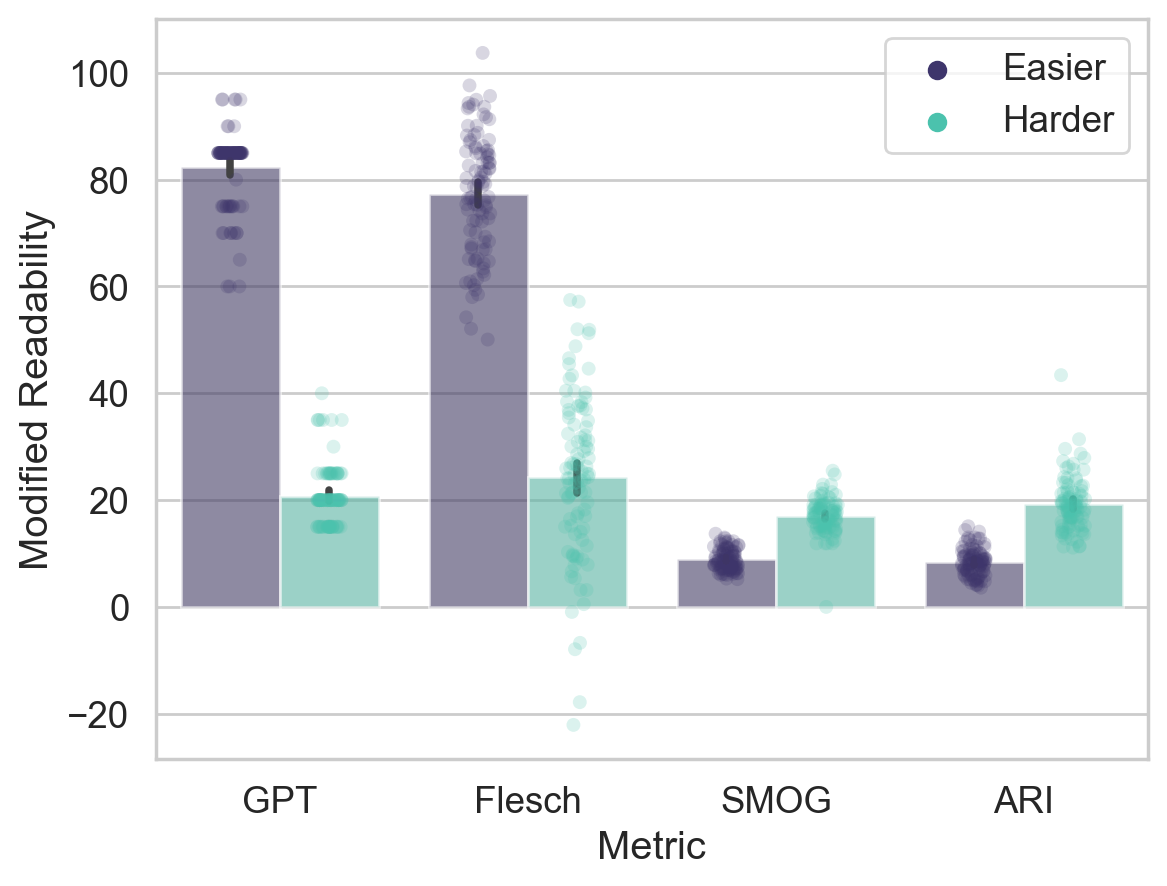

In [289]:
strip = sns.stripplot(data = df_results_subset_melted,
              x = "Metric", 
              y = "Outcome",
             hue = "Goal",
              dodge = True,
             palette = [color1, color2],
             alpha = .2)
bar = sns.barplot(data = df_results_subset_melted,
              x = "Metric", 
              y = "Outcome",
                  palette = [color1, color2],
             hue = "Goal",
             alpha = .6)

# To handle the legend (it might duplicate because of two plots)
handles, labels = strip.get_legend_handles_labels()
plt.legend(handles[:len(set(df_results_subset_melted['Goal']))], labels[:len(set(df_results_subset_melted['Goal']))])

plt.xlabel("Metric")
plt.ylabel("Modified Readability")

plt.savefig("Figures/modifications/all_metrics_raw.png", dpi = 300)


### Visualizing by modified readability metric

In [290]:
### Identify columns columns
columns_to_normalize = ['Modified_GPT', 'Modified_Flesch', 'Modified_SMOG', 'Modified_ARI']
new_columns = ['Modified_GPT_z', 'Modified_Flesch_z', 'Modified_SMOG_z', 'Modified_ARI_z']
### Apply z-score function
df_results[new_columns] = df_results[columns_to_normalize].apply(ss.zscore)
### Invert SMOG and ARI
df_results['Modified_SMOG_z (inverted)'] = df_results['Modified_SMOG_z'].apply(lambda x: -x)
df_results['Modified_ARI_z (inverted)'] = df_results['Modified_ARI_z'].apply(lambda x: -x)

In [291]:
df_results_subset = df_results[['Modified_GPT_z',
                               'Modified_Flesch_z',
                               'Modified_SMOG_z (inverted)',
                               'Modified_ARI_z (inverted)',
                               'Goal']]
df_results_subset_melted = pd.melt(df_results_subset, id_vars = 'Goal',
                                  var_name = "Metric", value_name = "Outcome")

In [292]:
df_results_subset_melted['Metric'] = df_results_subset_melted['Metric'].apply(lambda x: x.split("_")[1])
df_results_subset_melted['Goal'] = df_results_subset_melted['Goal'].apply(lambda x: x.title())

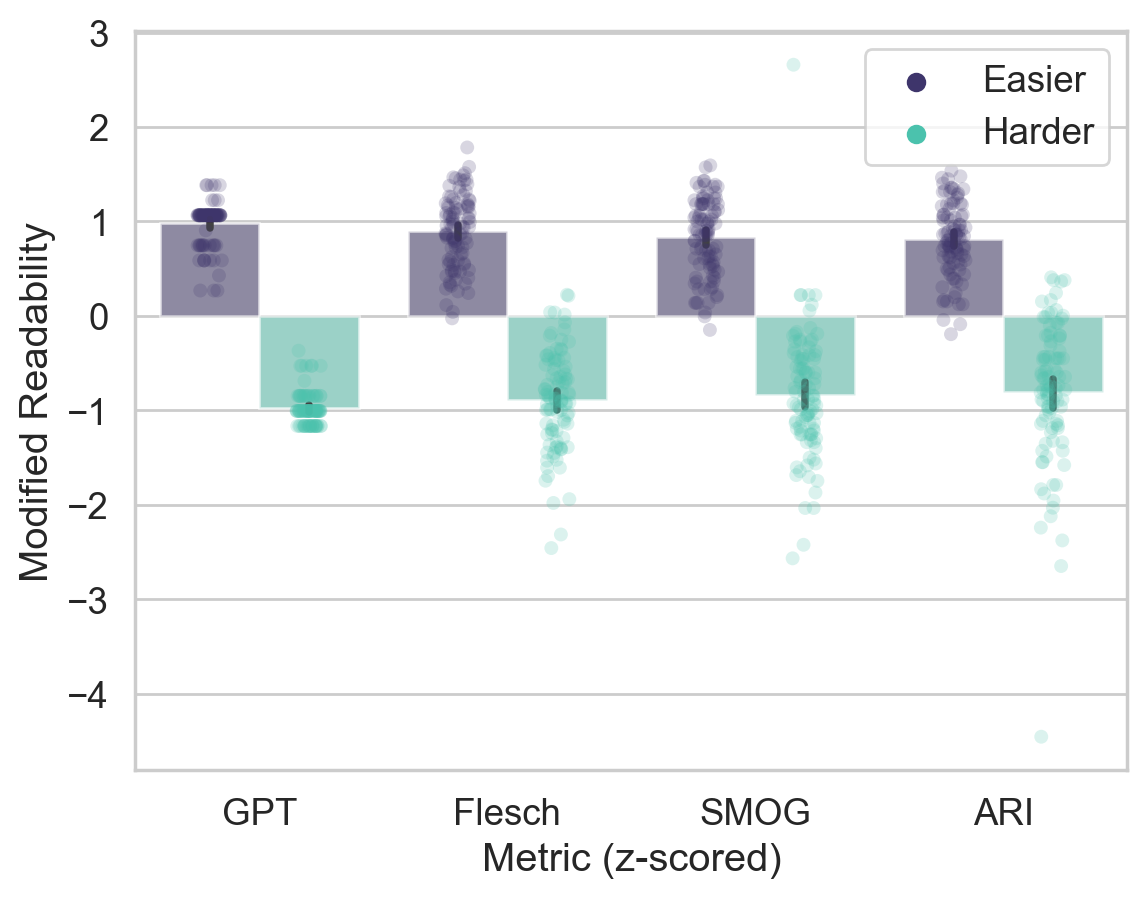

In [293]:
strip = sns.stripplot(data = df_results_subset_melted,
              x = "Metric", 
              y = "Outcome",
             hue = "Goal",
              dodge = True,
             palette = [color1, color2],
             alpha = .2)
bar = sns.barplot(data = df_results_subset_melted,
              x = "Metric", 
              y = "Outcome",
                  palette = [color1, color2],
             hue = "Goal",
             alpha = .6)

# To handle the legend (it might duplicate because of two plots)
handles, labels = strip.get_legend_handles_labels()
plt.legend(handles[:len(set(df_results_subset_melted['Goal']))], labels[:len(set(df_results_subset_melted['Goal']))])

plt.xlabel("Metric (z-scored)")
plt.ylabel("Modified Readability")

plt.savefig("Figures/modifications/all_metrics_z.png", dpi = 300)

### Visualizing by change in readability metric

Now we visualize by the *difference* between the `Original` readability and the `Modified`. Note that a key limitation here is the values are on very different axes.

In [294]:
df_results_subset = df_results[['GPT_diff',
                               'Flesch_diff',
                               'SMOG_diff',
                               'ARI_diff',
                               'Goal']]
df_results_subset_melted = pd.melt(df_results_subset, id_vars = 'Goal',
                                  var_name = "Metric", value_name = "Outcome")

In [295]:
df_results_subset_melted['Metric'] = df_results_subset_melted['Metric'].apply(lambda x: x.split("_")[0])
df_results_subset_melted['Goal'] = df_results_subset_melted['Goal'].apply(lambda x: x.title())

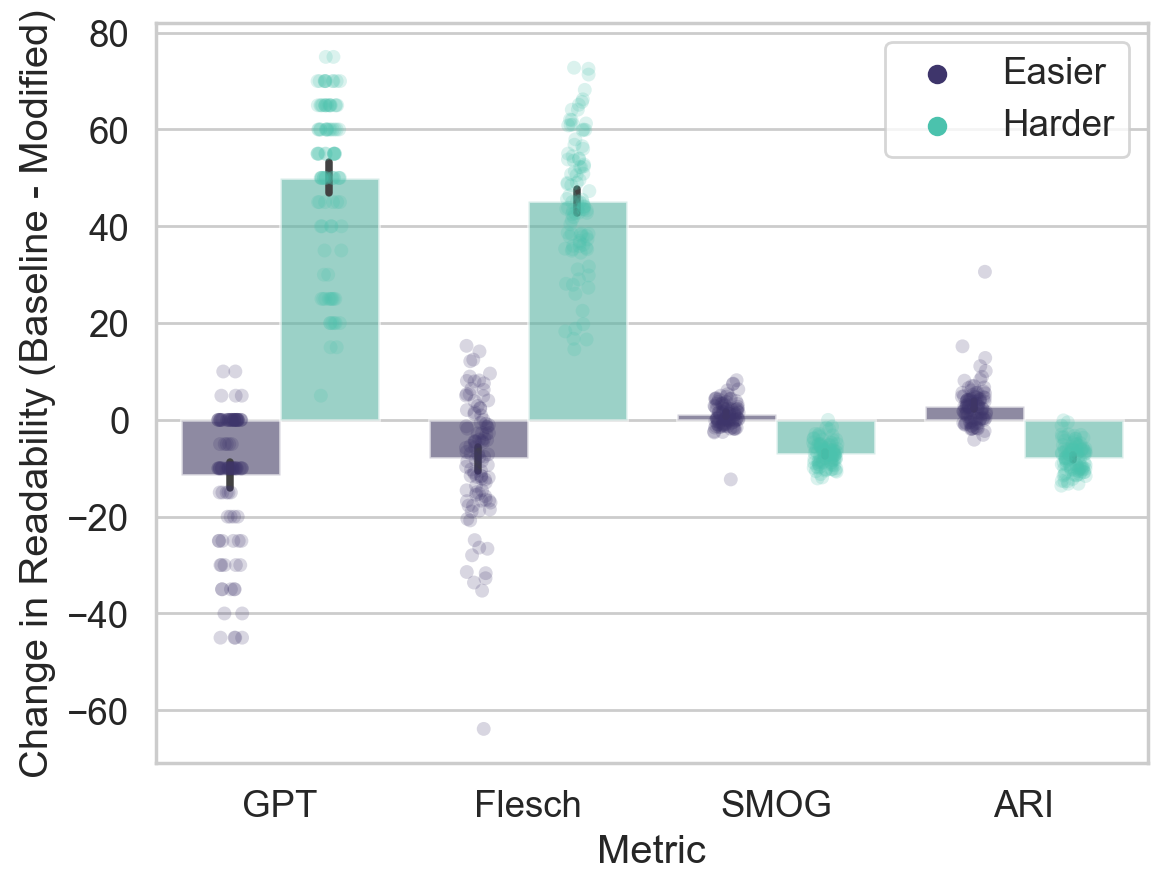

In [296]:

strip = sns.stripplot(data = df_results_subset_melted,
              x = "Metric", 
              y = "Outcome",
             hue = "Goal",
              dodge = True,
             palette = [color1, color2],
             alpha = .2)

bar = sns.barplot(data = df_results_subset_melted,
              x = "Metric", 
              y = "Outcome",
                  palette = [color1, color2],
             hue = "Goal",
             alpha = .6)

# To handle the legend (it might duplicate because of two plots)
handles, labels = strip.get_legend_handles_labels()
plt.legend(handles[:len(set(df_results_subset_melted['Goal']))], labels[:len(set(df_results_subset_melted['Goal']))])

plt.xlabel("Metric")
plt.ylabel("Change in Readability (Baseline - Modified)")

plt.savefig("Figures/modifications/all_metrics_raw_change.png", dpi = 300)

### Comparing original to new readability metric

/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


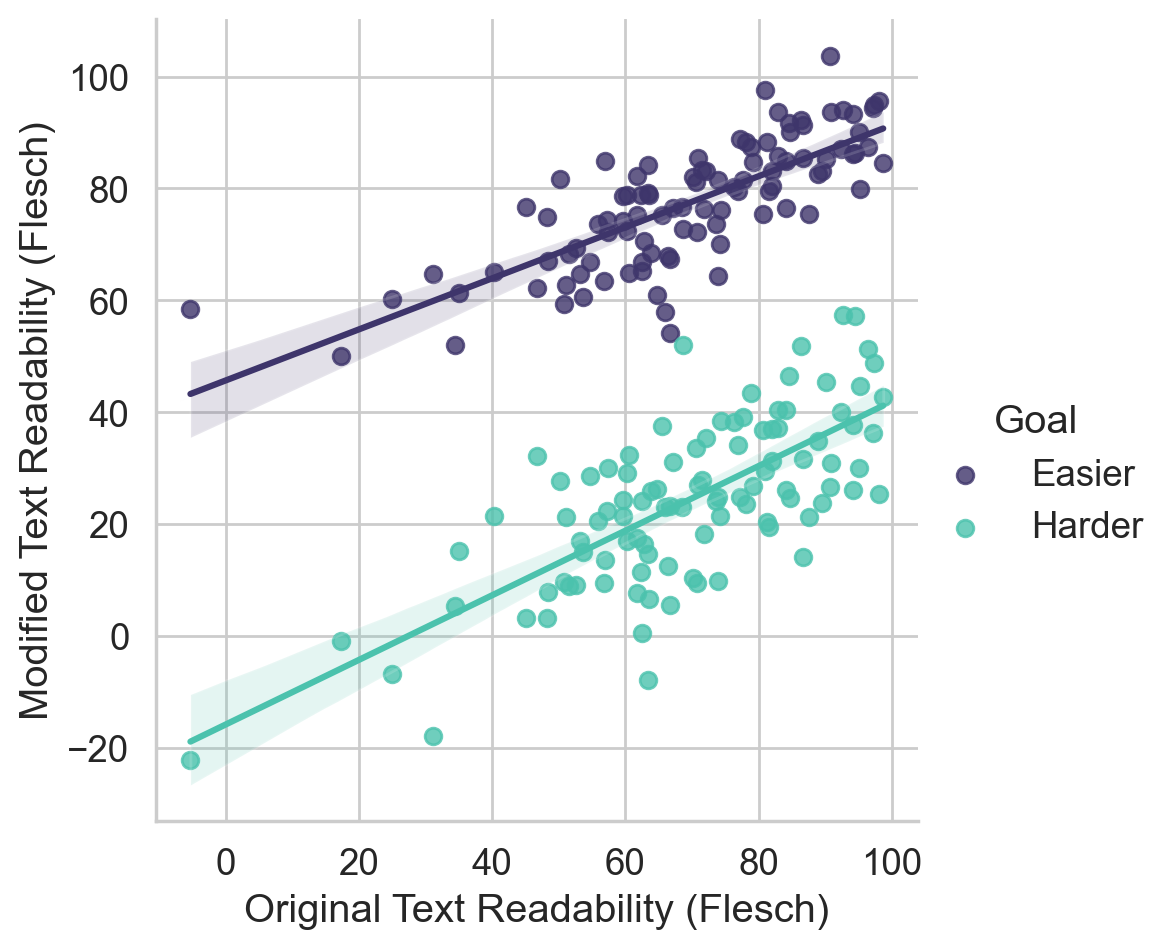

In [283]:
sns.lmplot(data = df_results, 
           x = "Og_Flesch", 
           y = "Modified_Flesch",
          hue = "Goal",
          palette = [color1, color2])

plt.xlabel("Original Text Readability (Flesch)")
plt.ylabel("Modified Text Readability (Flesch)")

plt.savefig("Figures/modifications/flesch_comparison.png", dpi = 300)

/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


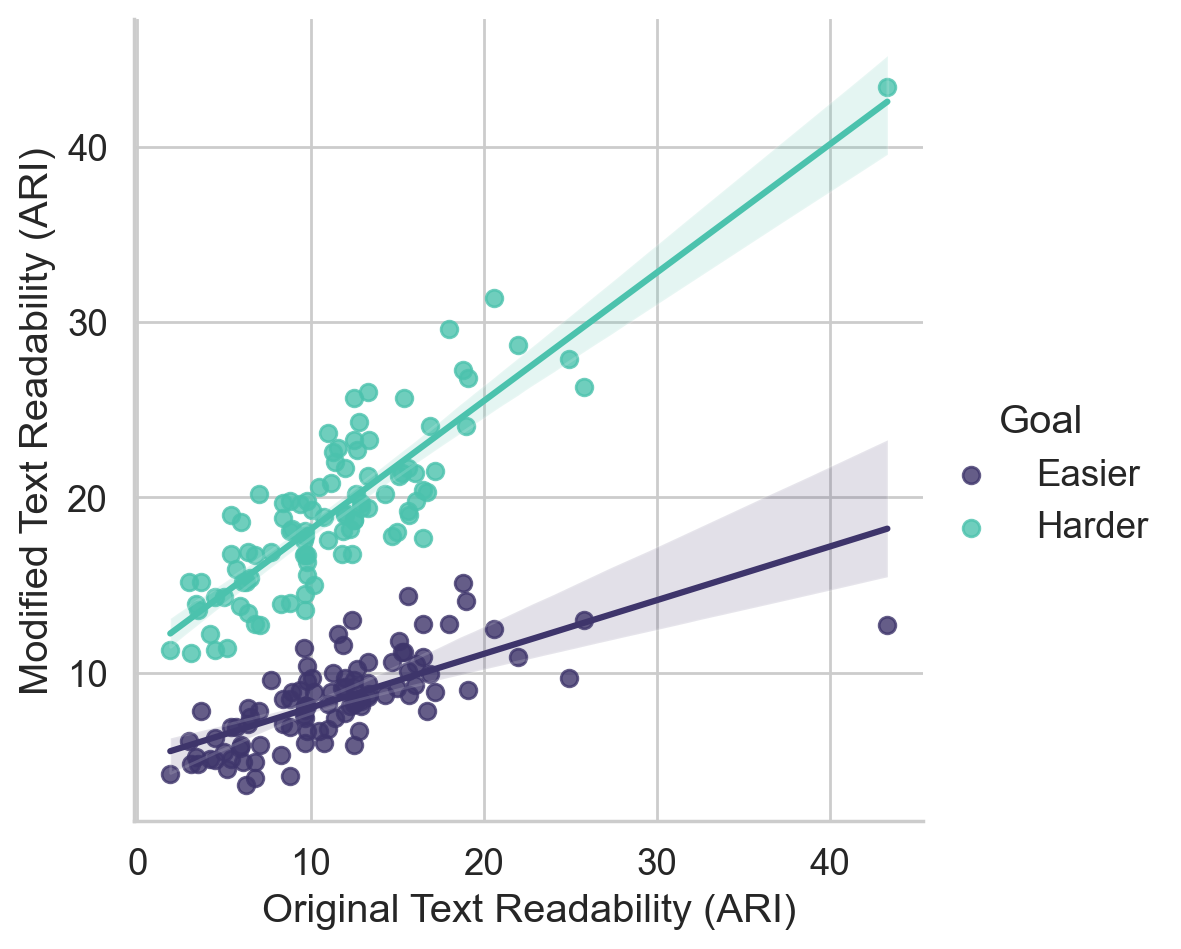

In [284]:
sns.lmplot(data = df_results, 
           x = "Og_ARI", 
           y = "Modified_ARI",
          hue = "Goal",
          palette = [color1, color2])

plt.xlabel("Original Text Readability (ARI)")
plt.ylabel("Modified Text Readability (ARI)")

plt.savefig("Figures/modifications/ARI_comparison.png", dpi = 300)

/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


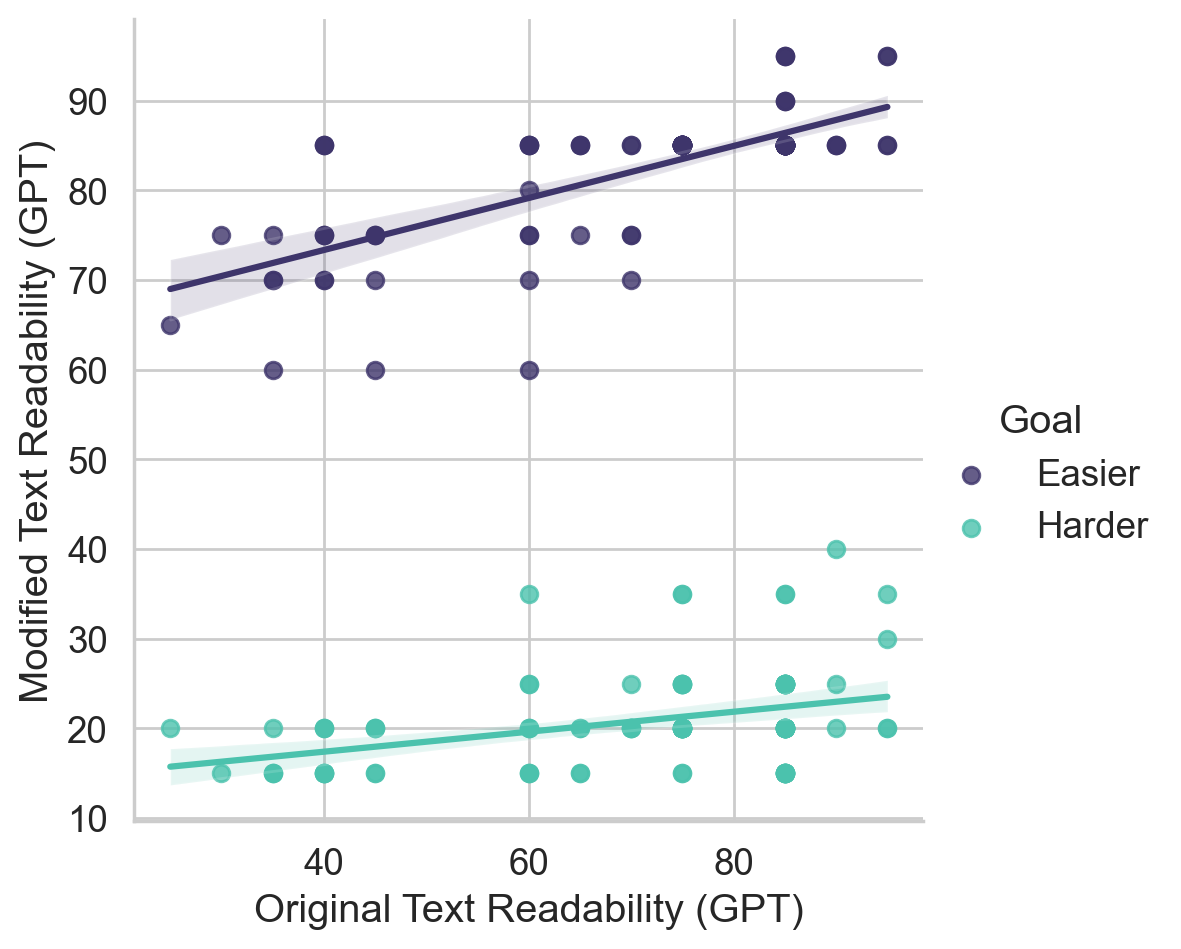

In [285]:
sns.lmplot(data = df_results, 
           x = "Og_GPT", 
           y = "Modified_GPT",
          hue = "Goal",
          palette = [color1, color2])

plt.xlabel("Original Text Readability (GPT)")
plt.ylabel("Modified Text Readability (GPT)")

plt.savefig("Figures/modifications/GPT_comparison.png", dpi = 300)

/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


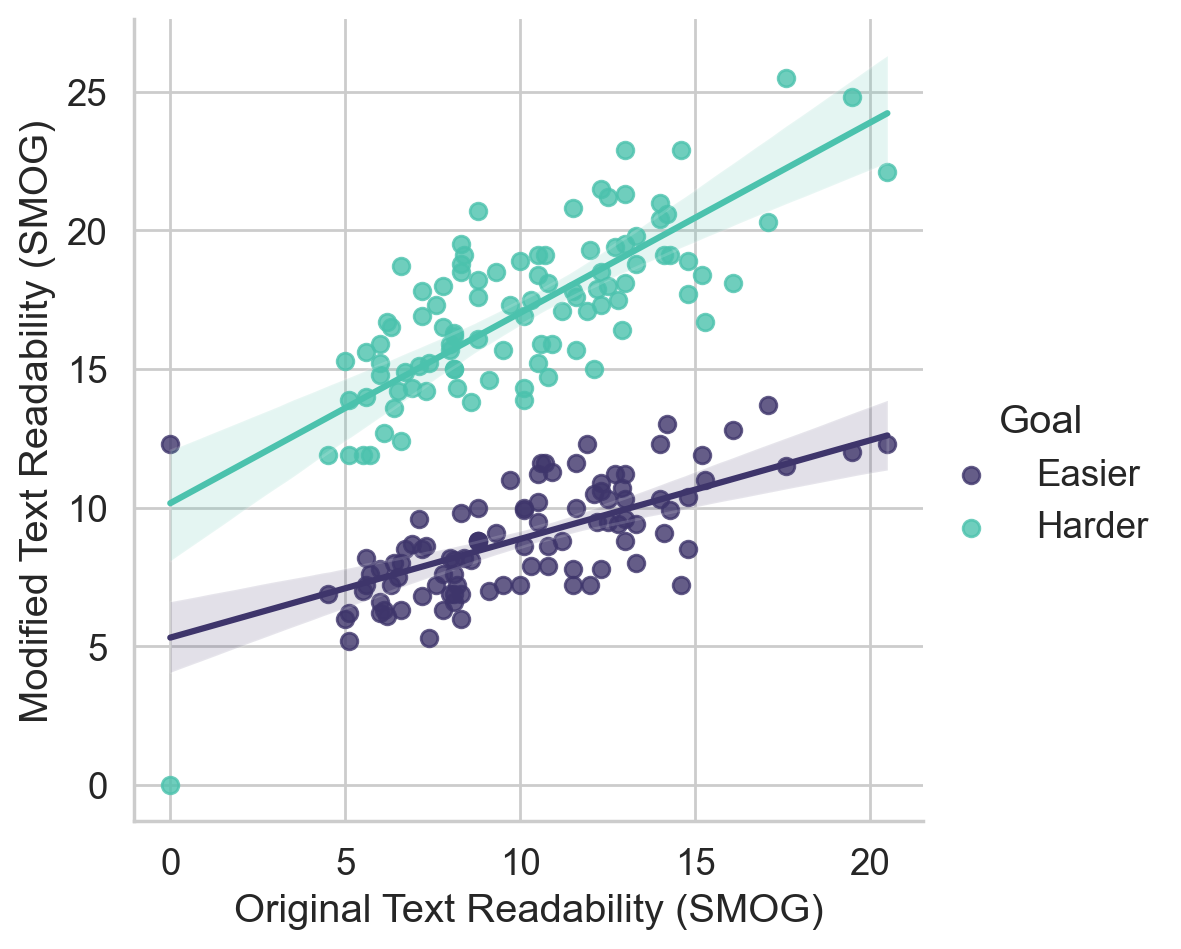

In [286]:
sns.lmplot(data = df_results, 
           x = "Og_SMOG", 
           y = "Modified_SMOG",
          hue = "Goal",
          palette = [color1, color2])

plt.xlabel("Original Text Readability (SMOG)")
plt.ylabel("Modified Text Readability (SMOG)")

plt.savefig("Figures/modifications/SMOG_comparison.png", dpi = 300)

## Qualitative examples

Finally, I inspect some examples to see what Turbo did.

In [14]:
### Display more characters per column
pd.set_option('display.max_colwidth', None)

### Easy examples

In [84]:
df_easy = df_results[df_results['Goal'] == "Easier"]

In [85]:
df_easy.sort_values("GPT_diff")[['Excerpt', 'GPT_Response', 'GPT_diff']].head(3)

,Excerpt,GPT_Response,GPT_diff
192,"But the sting certainly does not exhaust the whole philosophy of the nettle. Look, for example, at the stem and leaves. The nettle has found its chance in life, its one fitting vacancy, among the ditches and waste-places by roadsides or near cottages; and it has laid itself out for the circumstances in which it lives. Its near relative, the hop, is a twisting climber; its southern cousins, the fig and the mulberry, are tall and spreading trees. But the nettle has made itself a niche in nature along the bare patches which diversify human cultivation; and it has adapted its stem and leaves to the station in life where it has pleased Providence to place it. Plants like the dock, the burdock, and the rhubarb, which lift their leaves straight above the ground, from large subterranean reservoirs of material, have usually big, broad, undivided leaves, that overshadow all beneath them, and push boldly out on every side to drink in the air and the sunlight.","The nettle's story is more than just its sting. Take a look at its stem and leaves. The nettle has found its perfect spot in life, thriving in ditches and neglected areas by roads or near homes. It's perfectly suited for these environments. While its relative, the hop, climbs and twists, and its distant family members, the fig and mulberry, grow into large trees, the nettle has carved out its own space in the wild spots that break up our cultivated land. It has shaped its stem and leaves to fit the place it has found, or perhaps the place that fate has assigned it. Other plants with big underground stores, like the dock, burdock, and rhubarb, grow their leaves high off the ground. They have large, wide leaves that spread out to soak up the sun and air, overshadowing everything below.",-45.0
112,"So Carter Druse, bowing reverently to his father, who returned the salute with a stately courtesy that masked a breaking heart, left the home of his childhood to go soldiering. By conscience and courage, by deeds of devotion and daring, he soon commended himself to his fellows and his officers; and it was to these qualities and to some knowledge of the country that he owed his selection for his present perilous duty at the extreme outpost. Nevertheless, fatigue had been stronger than resolution and he had fallen asleep. What good or bad angel came in a dream to rouse him from his state of crime, who shall say? Without a movement, without a sound, in the profound silence and the languor of the late afternoon, some invisible messenger of fate touched with unsealing finger the eyes of his consciousness—whispered into the ear of his spirit the mysterious awakening word which no human lips ever have spoken, no human memory ever has recalled. He quietly raised his forehead from his arm and looked between the masking stems of the laurels, instinctively closing his right hand about the stock of his rifle. His first feeling was a keen artistic delight.","Carter Druse respectfully nodded to his father, who sadly returned the gesture with formal politeness, hiding his sorrow. Carter then left his childhood home to become a soldier. His strong sense of duty and bravery quickly earned him the respect of his peers and superiors. These traits, along with his knowledge of the area, led to his assignment to a dangerous position at a far-off outpost. Despite his determination, exhaustion overtook him, and he fell asleep. Who can say whether a good or bad spirit visited him in his dreams to wake him from this lapse? Without any noise or movement, in the quiet and stillness of the late afternoon, something unseen woke him up—speaking a secret word of awakening that no one has ever remembered. He silently lifted his head from his arm and peered through the bushes, instinctively gripping his rifle. His first emotion was a strong sense of pleasure.",-45.0
180,"In the seventeenth century, moreover, France owed much of her national power to a highly-centralized and closely-knit 

In [104]:
df_easy.sort_values("GPT_diff")[['Excerpt', 'GPT_Response', 'GPT_diff', 'Flesch_diff']].tail(2)

,Excerpt,GPT_Response,GPT_diff,Flesch_diff
68,"Fruit grows on plants all over the world. Different fruits come from different countries. These are apricots from Armenia. Fruits and vegetables are different. Fruits have seeds but vegetables don't. Some seeds are very big, like in a peach. Some seeds are tiny, like in a kiwi. Fruits have seeds to make new plants. When animals eat fruit ,they carry the seeds far away. This lets plants grow in new places. Fruits grow in different ways. Some grow together in groups. Others grow alone. Some fruits grow high up in the trees. Others grow close to the ground. Squash grows near the ground. People cook squash like a vegetable. It is a fruit because it has seeds. Fruits can look very different. They can be small like a lychee. They can be large like a melon. A watermelon is a very large fruit. Different fruits have different skin. Peaches feel soft and furry. Apples feel smooth and shiny. Lemons feel rough and hard. Sometimes the skin of a fruit is good to eat. Apples have skin you can eat. Sometimes the skin of fruit is not good to eat. Longan skin is not good to eat.","Fruits grow on plants all around the world, and they come from many different places. For example, apricots are from Armenia. It's important to know that fruits are not the same as vegetables. The main difference is that fruits have seeds, while vegetables usually don't. Seeds can vary in size; peach seeds are big, but kiwi seeds are very small. Seeds are important because they help create new fruit plants. When animals eat fruits, they spread the seeds far and wide, which helps plants grow in new areas.\n\nFruits can grow in various ways. Some fruits bunch together, while some grow by themselves. You'll find some fruits up high in trees and others down low, close to the ground, like squash. Even though people often cook squash as a vegetable, it's actually a fruit because it has seeds.\n\nFruits also come in many shapes and sizes. They can be tiny like a lychee or big like a melon. Watermelons are an example of a very large fruit. The skin of fruits is different too. Peaches have a soft, fuzzy skin, while apples are smooth and shiny, and lemons have a rough, hard skin. Sometimes you can eat the skin of a fruit, like with apples",10.0,14.15
52,"One day, Chat was strolling in the garden. She liked the sweet scent of flowers. She loved to touch their soft petals. Chat wished she could see flowers, just once. ""They are lovely,"" she said to herself. Every day, Chat walked in the garden. She knew her way around. Today, she raised her head to the skies. Suddenly, she heard thunder and lightning. ""I need to hurry back to the house,"" Chat thought. Rain began to fall. Chat slipped, lost her balance and fell. She hit her head on a stone. When Chat woke up, there were people around her. ""What happened?"" she asked. ""You fell and bumped your head,"" her father said. ""Thank God you are fine,"" said her mother. ""Daddy, mummy?"" asked Chat. She also called the names of her brothers and sisters. ""Please, get me a flower."" Everyone was surprised. Her sister returned with a flower. Chat held it gently. ""It is so lovely,"" she said. Her family looked at one another. ""Chat, can you see the flower?"" her mother asked. Chat played with the flower in her hand. ""You are all so beautiful, just like this flower,"" she smiled.","Chat was walking in the garden, enjoying the sweet smell of the flowers and the feel of their soft petals. She always wished she could see them. ""They must be beautiful,"" she thought. Chat walked in the garden every day and knew it well. Today, she looked up at the sky and suddenly heard thunder and saw flashes of lightning. ""I should get back home quickly,"" she realized. Then the rain started pouring down. As she hurried, Chat slipped and fell, hitting her head on a rock. When she woke up, her family was around her. ""What happened?"" she asked. ""You had a fall and hit your head,"" her dad explained. ""We

### Hard examples

In [87]:
df_hard = df_results[df_results['Goal'] == "Harder"]

In [89]:
df_hard.sort_values("GPT_diff")[['Excerpt', 'GPT_Response', 'GPT_diff']].tail(3)

,Excerpt,GPT_Response,GPT_diff
91,"So, we went into the Home of the Street Sweepers. It is a grey house on a narrow street. There is a sundial in its courtyard, by which the Council of the Home can tell the hours of the day and when to ring the bell. When the bell rings, we all arise from our beds. The sky is green and cold in our windows to the east. The shadow on the sundial marks off a half-hour while we dress and eat our breakfast in the dining hall, where there are five long tables with twenty clay plates and twenty clay cups on each table. Then we go to work in the streets of the City, with our brooms and our rakes. In five hours, when the sun is high, we return to the Home and we eat our midday meal, for which one-half hour is allowed.","Consequently, our ingress was directed towards the domicile of the Street Sweepers, an edifice of unremarkable grey hue situated along a constricted thoroughfare. Within its confines, a gnomon-based timepiece adorns the quadrangle, serving the Council of the Home as an instrument for the ascertainment of diurnal intervals and the subsequent instigation of the bell's toll. Upon the auditory signal's dissemination, a collective emergence from our repose is mandated. The firmament, observed through our eastern apertures, presents a verdant and frigid tableau. The advancing penumbra upon the timepiece delineates a demisemiquaver of the hour, during which we attire ourselves and partake of the morning's repast within the refectory, a space furnished with quintuple elongated tables, each bearing an alignment of twenty argillaceous",70.0
75,"Once upon a time, there was a hungry jackal. He was walking around the bush looking for food. He came across a grapevine. He spotted a bunch of juicy ripe grapes hanging from a high branch. ""Those look really delicious,"" he thought. He took a few steps back so that he could make his highest jump. The grapes were too high. Jackal fell on his back without even touching the bunch. Jackal got up and went further back from his starting spot. He ran, and almost got high enough. But he fell, even harder. He tried again and again. But he couldn't get to the grapes. He kept falling until his back was very sore. Finally, he gave up and walked away. He stopped and looked back at the grapes. He was hungrier than ever. ""Those grapes look really sour anyway,"" he thought.","In an epoch long past, there existed a famished Canis aureus, meandering the dense underbrush in quest of sustenance. In the midst of his perambulation, he chanced upon a Vitis vinifera, his gaze alighting upon a cluster of succulent, mature grapes suspended from an elevated limb. ""Verily, those appear to be of an exquisite savor,"" he mused internally. He repositioned himself posteriorly with the intent to execute an ascent of maximal altitude. Alas, the grapes remained elusive, positioned too loftily. The jackal descended upon his dorsal aspect, failing to graze the cluster with even the tips of his digits. Undeterred, the jackal retreated further from his initial locus, commenced a sprint, and nearly attained a height sufficient. Yet, he plummeted, with increased vehemence. His attempts persisted",75.0
53,"One day, Chat was strolling in the garden. She liked the sweet scent of flowers. She loved to touch their soft petals. Chat wished she could see flowers, just once. ""They are lovely,"" she said to herself. Every day, Chat walked in the garden. She knew her way around. Today, she raised her head to the skies. Suddenly, she heard thunder and lightning. ""I need to hurry back to the house,"" Chat thought. Rain began to fall. Chat slipped, lost her balance and fell. She hit her head on a stone. When Chat woke up, there were people around her. ""What happened?"" she asked. ""You fell and bumped your head,"" her father said. ""Thank God you are fine,"" said her mother. ""Daddy, mummy?"" asked Chat. She also called the names of her brothers and sisters. ""Please, get me a flower."" Everyone was su

In [90]:
df_hard.sort_values("GPT_diff")[['Excerpt', 'GPT_Response', 'GPT_diff']].head(3)

,Excerpt,GPT_Response,GPT_diff
33,"Temperature-programmed reduction (TPR) is a technique for the characterization of solid materials and is often used in the field of heterogeneous catalysis to find the most efficient reduction conditions, an oxidized catalyst precursor is submitted to a programmed temperature rise while a reducing gas mixture is flowed over it. It was developed by John Ward Jenkins whilst developing heterogeneous catalysts for Shell Oil company, but was never patented. A simple container (U-tube) is filled with a solid or catalyst. This sample vessel is positioned in a furnace with temperature control equipment. A thermocouple is placed in the solid for temperature measurement. The air originally present in the container is flushed out with an inert gas (nitrogen, argon). Flow controllers are used to add hydrogen (for example, 10 Vol -% hydrogen in nitrogen). The composition of the gaseous mixture is measured at the exit of the sample container with appropriate detectors (thermal conductivity detector, mass spectrometer).","Temperature-programmed reduction (TPR), an analytical methodology for the elucidation of solid-state substances' characteristics, predominantly finds its utility within the domain of heterogeneous catalysis for the optimization of efficacious reduction parameters. In this process, an oxidized catalyst precursor undergoes a meticulously orchestrated thermal escalation under the influence of a reductive gaseous amalgam that is percolated over the substance. The genesis of this technique is attributed to John Ward Jenkins during his tenure at Shell Oil Company in the pursuit of advancing heterogeneous catalysts, yet it remained devoid of patent protection. A rudimentary receptacle, often a U-shaped tube, is charged with a solid or a catalyst specimen. This vessel is then ensconced within a furnace equipped with precision temperature modulation apparatus. To ascertain the thermal state of the solid, a thermocouple is embedded therein. Prior to commencing the procedure, the ambient air within the container is purged and supplanted with an inert gas such as nitrogen or",5.0
133,"At a recent meeting of the London Physical Society, Prof. Rowland, of Baltimore, exhibited a number of his new concave gratings for giving a diffraction spectrum. He explained the theory of their action. Gratings can be ruled on any surface, if the lines are at a proper distance apart and of the proper form. The best surface, however, is a cylindrical or spherical one. The gratings are solid slabs of polished speculum metal ruled with lines equidistant by a special machine of Prof. Rowland's invention. An account of this machine will be published shortly. The number of lines per inch varied in the specimens shown from 5,000 to 42,000, but higher numbers can be engraved by the cutting diamond. The author has designed an ingenious mechanical arrangement for keeping the photographic plates in focus. In this way photographs of great distinctness can be obtained. Prof. Rowland exhibited some 10 inches long, which showed the E line doubled, and the large B group very clearly.","In the context of a recent convocation of the esteemed London Physical Society, the distinguished Prof. Rowland, hailing from the academic precincts of Baltimore, presented an array of his novel concave diffraction gratings. He elucidated upon the theoretical underpinnings governing their operational mechanics. It is conceivable to inscribe gratings upon any substrate, provided that the incisions are meticulously spaced with precision and sculpted into the correct configuration. Notwithstanding, the quintessential substrates for this purpose are those of a cylindrical or spherical geometry. These gratings are constituted from substantial slabs of lustrously polished speculum alloy, upon which lines are inscribed at uniform intervals utilizing a bespoke apparatus, a brainchild of Prof. Rowland. An exegesis detailing the intricacies of this contrivance is